# B.3 : survival analysis problem, GCN Cox Model, impact of mutational signatures
In this notebook, we compare, for the survival analysis problem with the GCN Cox Model, the following configurations :
- without mutational signatures (only biomarkers from the reference article : https://doi.org/10.1158/1078-0432.CCR-20-1163)
- with only mutational signatures
- with combination of reference article biomarkers and the mutational signatures

## Table of contents

1. [No mutational signatures](#1-no-sigmut)
2. [Only mutational signatures](#2-only-sigmut)
3. [Initial biomarkers + mutational signatures](#3-not-normalized-sigmut)
4. [Evaluate performances](#4-performances)

In [ ]:
# Move to the root of the repository
import sys
sys.path.append("..")

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.evaluation.SurvivalMetrics import SurvivalMetrics

from src.manage.GNNCoxTrainTestManager import GNNCoxTrainTestManager

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import from_networkx

from src.utils.FeatureSelector import FeatureSelector
from src.utils.PreProcessor import PreProcessor

#### Set hyper-parameters

In [34]:
lr = 0.005
reg = 0.005
n_features = 6
n_epochs = 100
max_neighbors = 2
architecture = 'gcn'

#### Reading and PreProcessor

In [35]:
# Reading dataset
df = pd.read_excel('../data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = PreProcessor.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = PreProcessor.relabel_patients(df, "Progression_1", "Time to progression (days)", t)
df = PreProcessor.relabel_patients(df, "Alive_0", "Overall survival (days)", t)

# Normalize initial biomarkers
features_to_normalize = ["Age at advanced disease diagnosis",
                         "CD8+ T cell score",
                         "Genome mut per mb",
                         "Exome mut per mb",
                         "CD274 expression",
                         "M1M2 expression"]

df.loc[:, features_to_normalize] = PreProcessor.normalize_data(df.loc[:, features_to_normalize])

# Select group
group = df["Tumour type"].to_numpy()

# Extract labels
# TTP :
y_clf_ttp = df["Progression_1"].to_numpy()
y_cox_ttp = np.array(list((df[['Progression_1', 'Time to progression (days)']].itertuples(index=False, name=None))),
                        dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

# OS :
y_clf_os = df["Alive_0"].to_numpy()
y_cox_os = np.array(list((df[['Alive_0', 'Overall survival (days)']].itertuples(index=False, name=None))),
                    dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

### 1. No mutational signatures

#### Feature selection

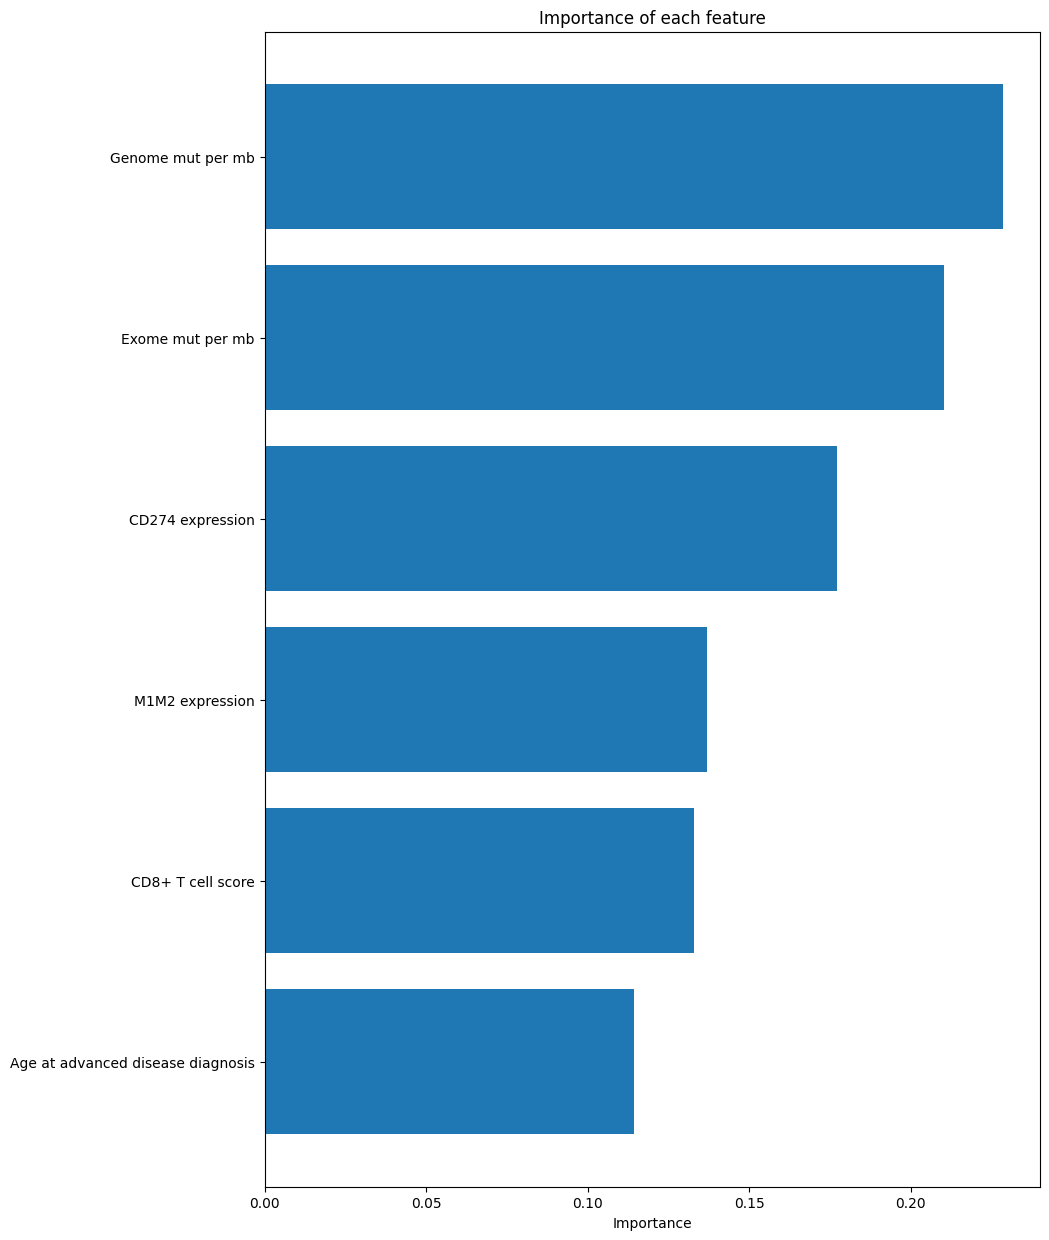

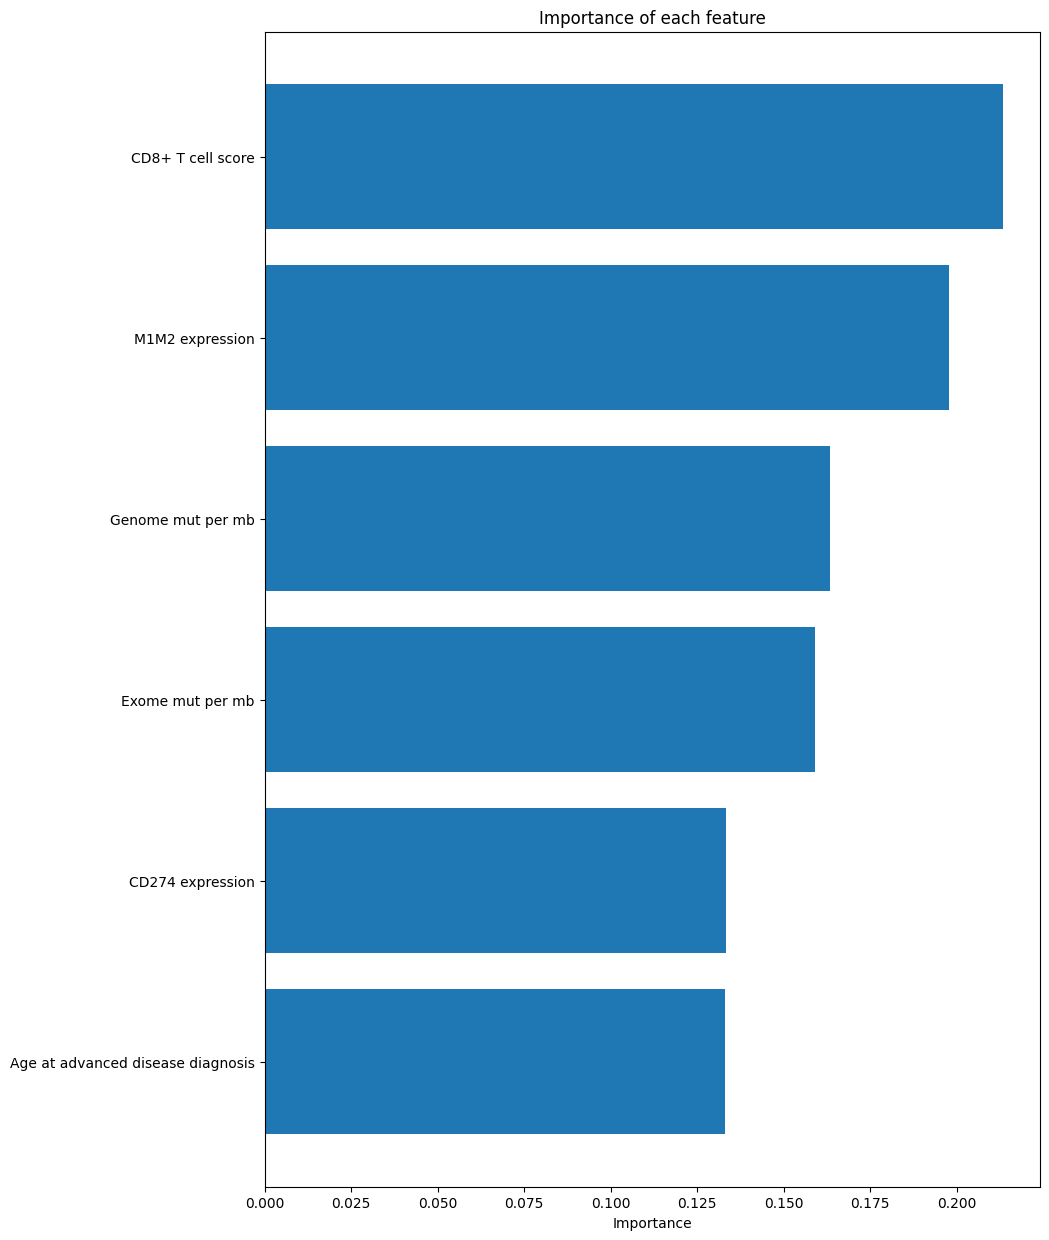

In [36]:
features_name_no_sigmut = ["Age at advanced disease diagnosis",
                           "CD8+ T cell score",
                           "Genome mut per mb",
                           "Exome mut per mb",
                           "CD274 expression",
                           "M1M2 expression"]

# Compute feature importance
# TTP :
features_name_no_sigmut_ttp = FeatureSelector.feature_importance(df.loc[:, features_name_no_sigmut], y_clf_ttp, True)
features_name_no_sigmut_os = FeatureSelector.feature_importance(df.loc[:, features_name_no_sigmut], y_clf_os, True)

# Select the most n_features important features
if n_features < len(features_name_no_sigmut):
    features_name_no_sigmut_ttp = features_name_no_sigmut_ttp[:n_features]
    features_name_no_sigmut_os = features_name_no_sigmut_os[:n_features]

# Extract features
X_no_sigmut_ttp = df.loc[:, features_name_no_sigmut_ttp].to_numpy()
X_no_sigmut_os = df.loc[:, features_name_no_sigmut_os].to_numpy()

#### Make the leave one out CV

In [21]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_no_sigmut_ttp = GNNCoxTrainTestManager(architecture)
risk_scores_no_sigmut_ttp, risk_classes_no_sigmut_ttp, nx_graph_no_sigmut_ttp = manager_no_sigmut_ttp.leave_one_out_cv(X_no_sigmut_ttp, y_clf_ttp, y_cox_ttp, group, n_epochs, lr, reg, max_neighbors)
# OS :
manager_no_sigmut_os = GNNCoxTrainTestManager(architecture)
risk_scores_no_sigmut_os, risk_classes_no_sigmut_os, nx_graph_no_sigmut_os = manager_no_sigmut_os.leave_one_out_cv(X_no_sigmut_os,y_clf_os, y_cox_os, group, n_epochs, lr, reg, max_neighbors)

### 2. Only mutational signatures

#### Feature selection

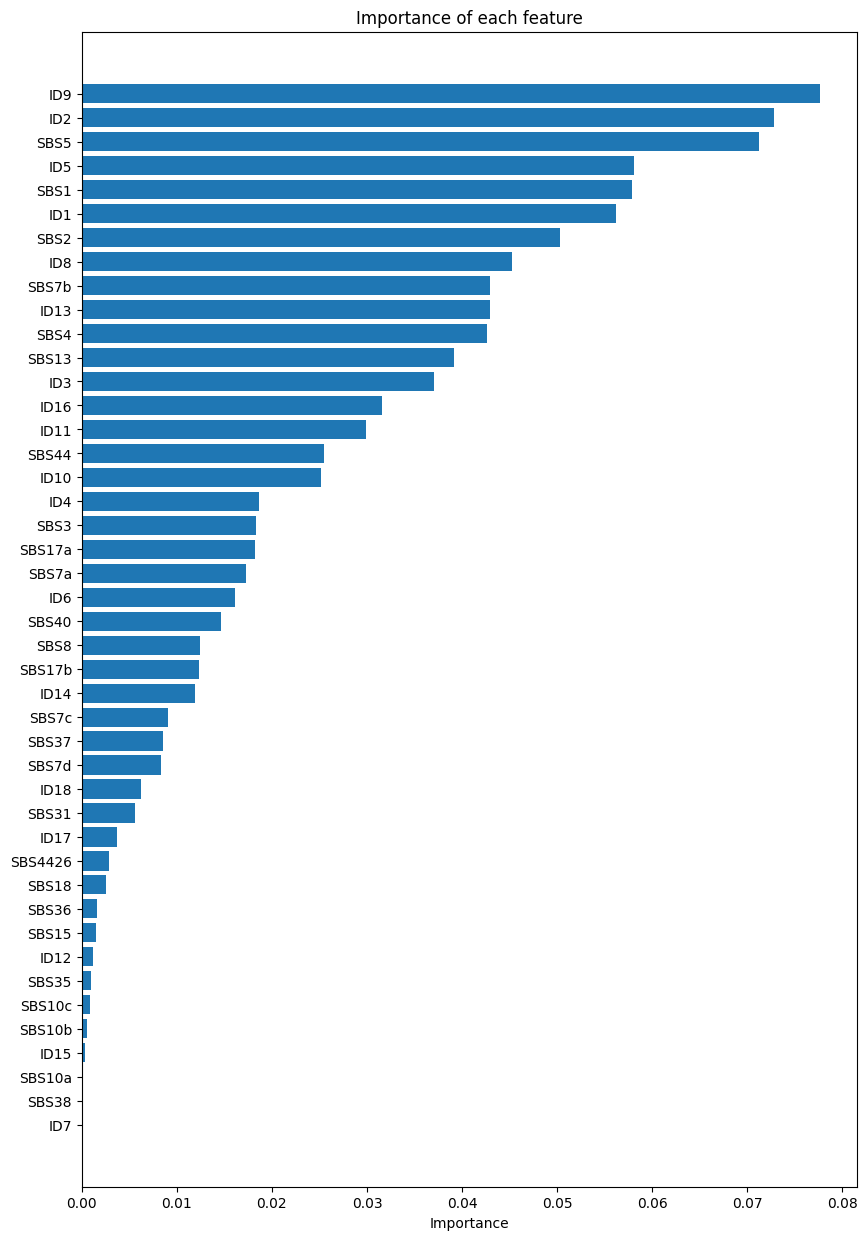

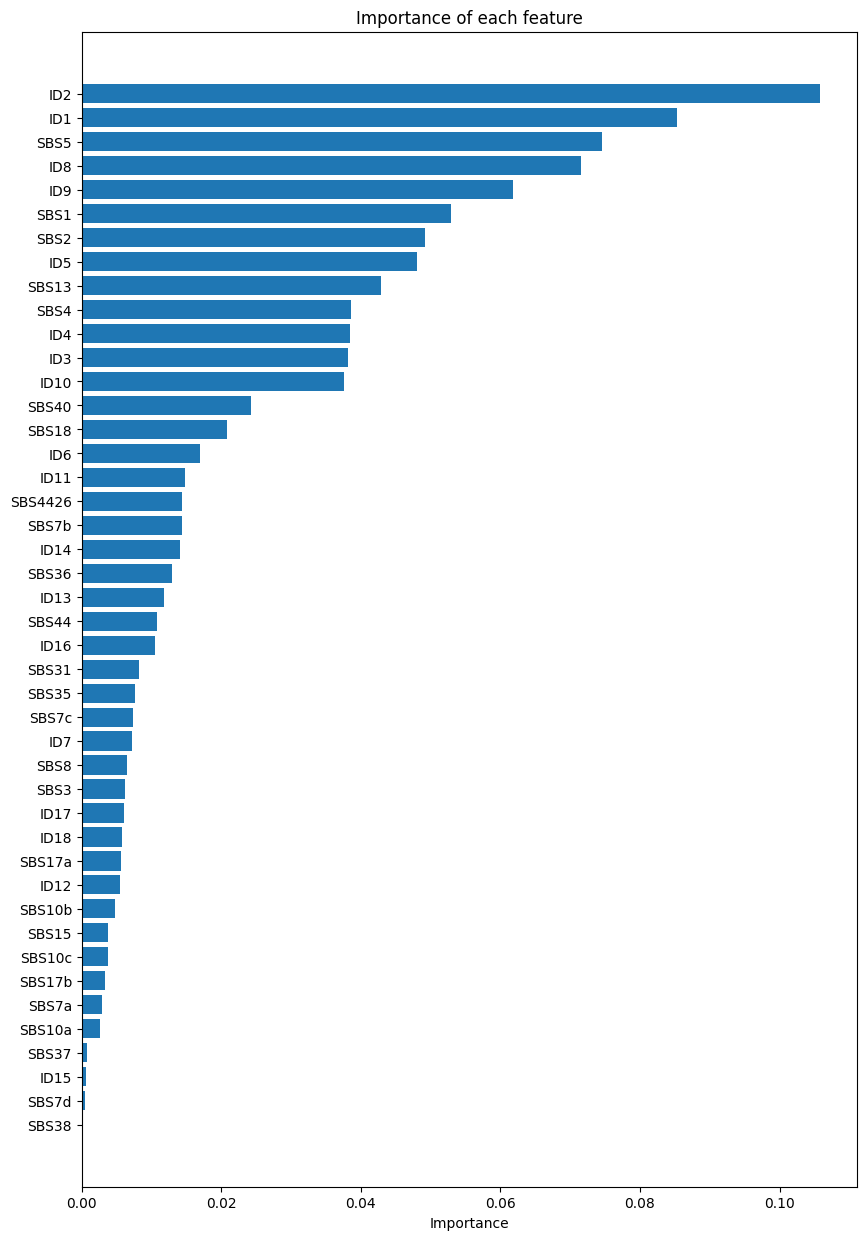

In [22]:
features_name_only_sigmut = ["SBS1",
                             "SBS2",
                             "SBS3",
                             "SBS4",
                             "SBS5",
                             "SBS7a",
                             "SBS7b",
                             "SBS7c",
                             "SBS7d",
                             "SBS8",
                             "SBS10a",
                             "SBS10b",
                             "SBS10c",
                             "SBS13",
                             "SBS15",
                             "SBS17a",
                             "SBS17b",
                             "SBS18",
                             "SBS31",
                             "SBS35",
                             "SBS36",
                             "SBS37",
                             "SBS38",
                             "SBS40",
                             "SBS44",
                             "SBS4426",
                             "ID1",
                             "ID2",
                             "ID3",
                             "ID4",
                             "ID5",
                             "ID6",
                             "ID7",
                             "ID8",
                             "ID9",
                             "ID10",
                             "ID11",
                             "ID12",
                             "ID13",
                             "ID14",
                             "ID15",
                             "ID16",
                             "ID17",
                             "ID18"]

# Compute feature importance
# TTP :
features_name_only_sigmut_ttp = FeatureSelector.feature_importance(df.loc[:, features_name_only_sigmut], y_clf_ttp, True)
features_name_only_sigmut_os = FeatureSelector.feature_importance(df.loc[:, features_name_only_sigmut], y_clf_os, True)

# Select the most n_features important features
if n_features < len(features_name_only_sigmut):
    features_name_only_sigmut_ttp = features_name_only_sigmut_ttp[:n_features]
    features_name_only_sigmut_os = features_name_only_sigmut_os[:n_features]

# Extract features
X_only_sigmut_ttp = df.loc[:, features_name_only_sigmut_ttp].to_numpy()
X_only_sigmut_os = df.loc[:, features_name_only_sigmut_os].to_numpy()

#### Make the leave one out CV

In [23]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_only_sigmut_ttp = GNNCoxTrainTestManager(architecture)
risk_scores_only_sigmut_ttp, risk_classes_only_sigmut_ttp, nx_graph_only_sigmut_ttp = manager_only_sigmut_ttp.leave_one_out_cv(X_only_sigmut_ttp, y_clf_ttp, y_cox_ttp, group, n_epochs, lr, reg, max_neighbors)
# OS :
manager_only_sigmut_os = GNNCoxTrainTestManager(architecture)
risk_scores_only_sigmut_os, risk_classes_only_sigmut_os, nx_graph_only_sigmut_os = manager_only_sigmut_os.leave_one_out_cv(X_only_sigmut_os,y_clf_os, y_cox_os, group, n_epochs, lr, reg, max_neighbors)

### 3. Initial biomarkers + mutational signatures

#### Feature selection

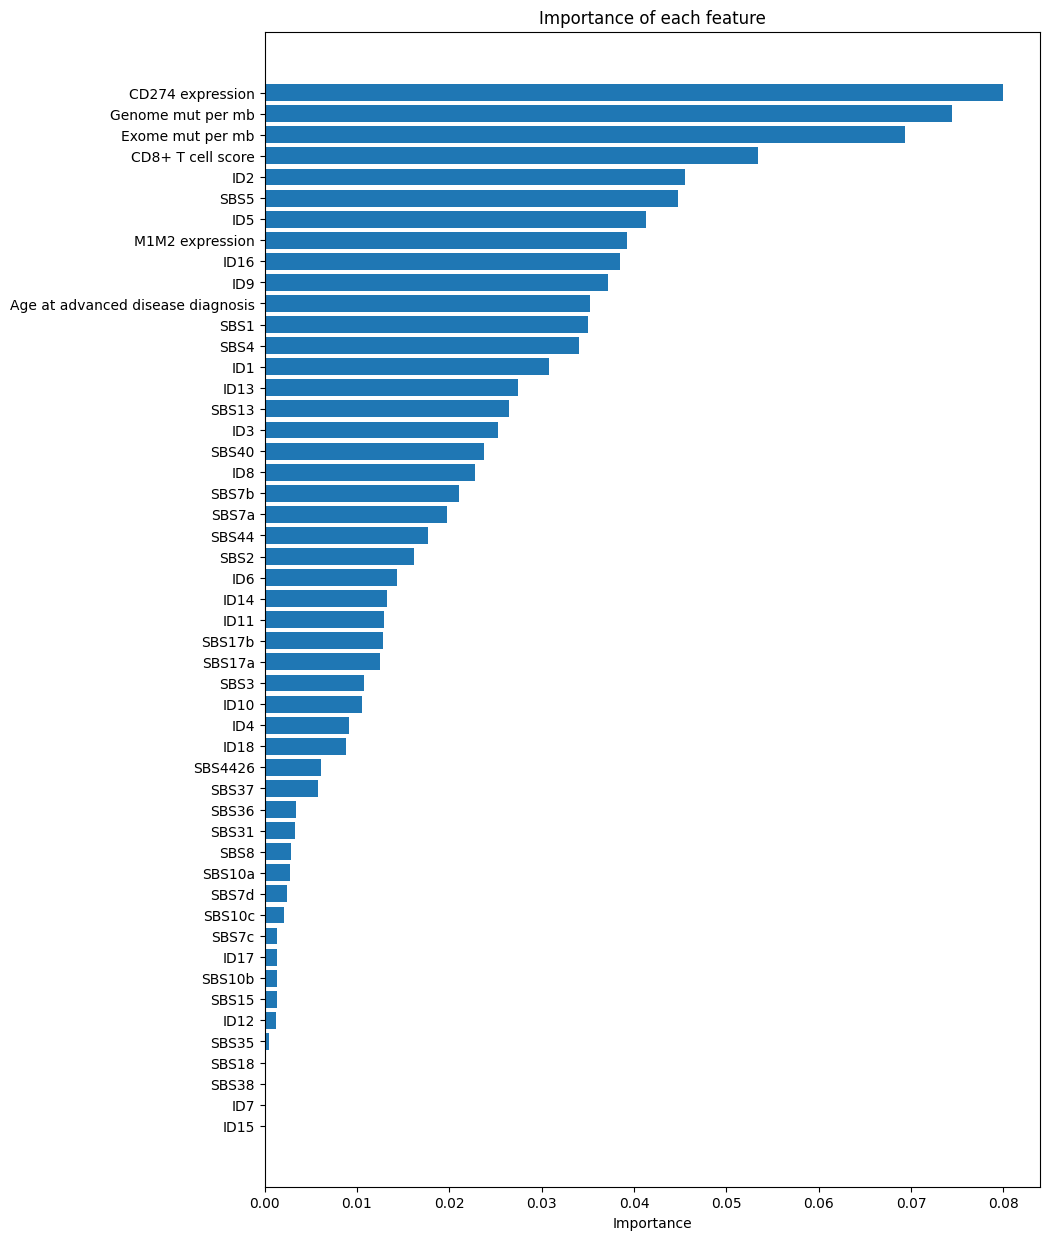

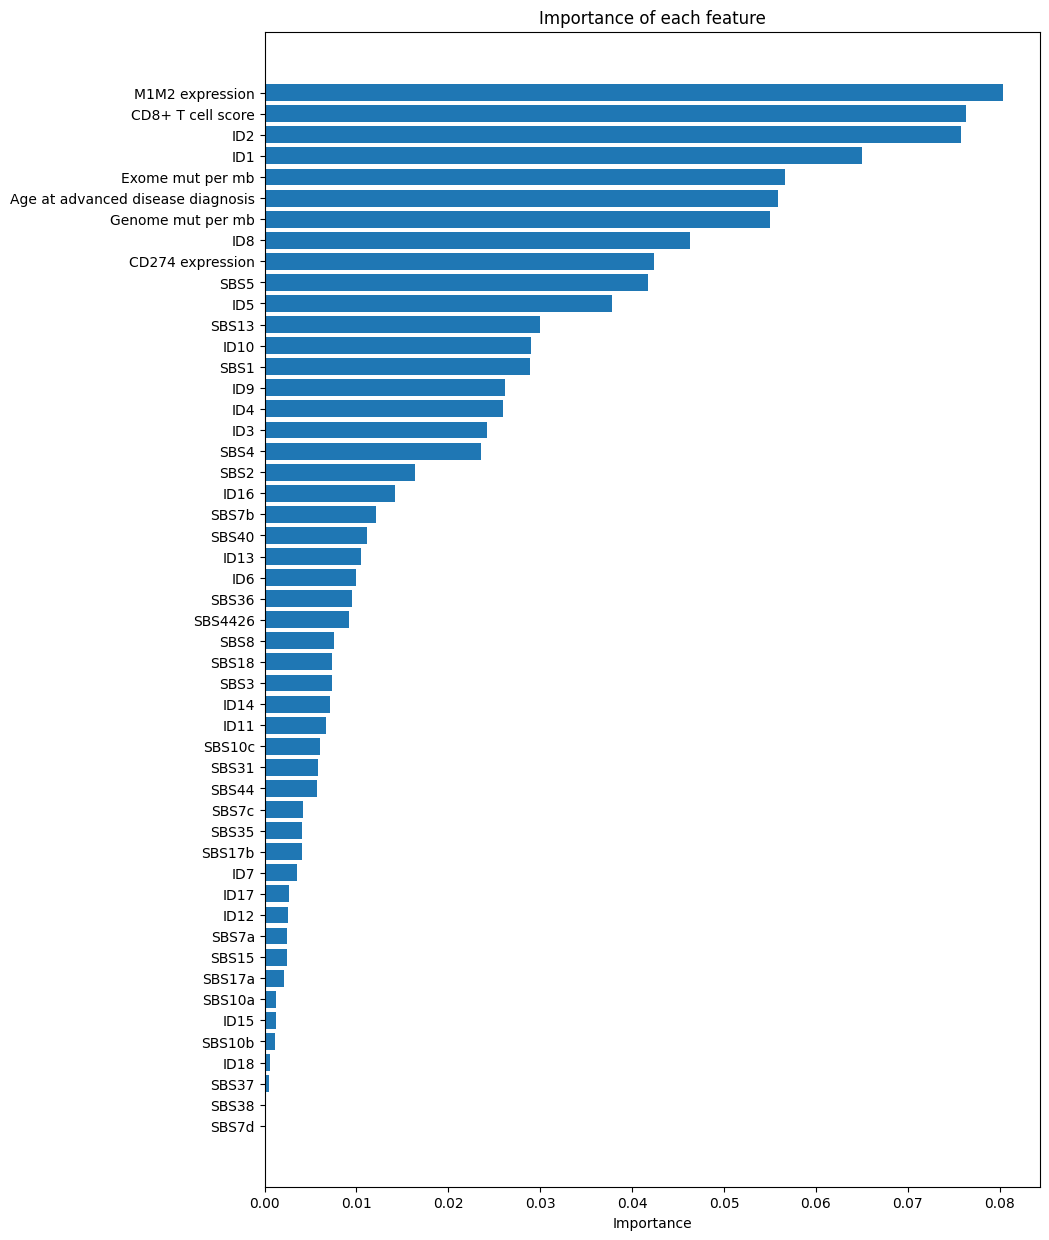

In [24]:
features_name_comb = ["Age at advanced disease diagnosis",
                      "CD8+ T cell score",
                      "Genome mut per mb",
                      "Exome mut per mb",
                      "CD274 expression",
                      "M1M2 expression",
                      "SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

# Compute feature importance
# TTP :
features_name_comb_ttp = FeatureSelector.feature_importance(df.loc[:, features_name_comb], y_clf_ttp, True)
features_name_comb_os = FeatureSelector.feature_importance(df.loc[:, features_name_comb], y_clf_os, True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb_ttp = features_name_comb_ttp[:n_features]
    features_name_comb_os = features_name_comb_os[:n_features]

# Extract features
X_comb_ttp = df.loc[:, features_name_comb_ttp].to_numpy()
X_comb_os = df.loc[:, features_name_comb_os].to_numpy()

#### Make the leave one out CV

In [25]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_comb_ttp = GNNCoxTrainTestManager(architecture)
risk_scores_comb_ttp, risk_classes_comb_ttp, nx_graph_comb_ttp = manager_comb_ttp.leave_one_out_cv(X_comb_ttp, y_clf_ttp, y_cox_ttp, group, n_epochs, lr, reg, max_neighbors)
# OS :
manager_comb_os = GNNCoxTrainTestManager(architecture)
risk_scores_comb_os, risk_classes_comb_os, nx_graph_comb_os = manager_comb_os.leave_one_out_cv(X_comb_os,y_clf_os, y_cox_os, group, n_epochs, lr, reg, max_neighbors)

### 4. Evaluate performances

In [26]:
status_ttp, time_ttp = df['Progression_1'].to_numpy().astype(bool), df['Time to progression (days)'].to_numpy()
status_os, time_os = df['Alive_0'].to_numpy().astype(bool), df['Overall survival (days)'].to_numpy()

#### SHAP values

In [27]:
# No sigmut
pyg_graph_no_sigmut_ttp = from_networkx(nx_graph_no_sigmut_ttp)
pyg_graph_no_sigmut_os = from_networkx(nx_graph_no_sigmut_os)
# TTP :
explainer_no_sigmut_ttp = Explainer(
    model=manager_no_sigmut_ttp.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_no_sigmut_ttp = explainer_no_sigmut_ttp(pyg_graph_no_sigmut_ttp.x, pyg_graph_no_sigmut_ttp.edge_index)
# OS :
explainer_no_sigmut_os = Explainer(
    model=manager_no_sigmut_os.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_no_sigmut_os = explainer_no_sigmut_os(pyg_graph_no_sigmut_os.x, pyg_graph_no_sigmut_os.edge_index)

# Only sigmut
pyg_graph_only_sigmut_ttp = from_networkx(nx_graph_only_sigmut_ttp)
pyg_graph_only_sigmut_os = from_networkx(nx_graph_only_sigmut_os)
# TTP :
explainer_only_sigmut_ttp = Explainer(
    model=manager_only_sigmut_ttp.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_only_sigmut_ttp = explainer_only_sigmut_ttp(pyg_graph_only_sigmut_ttp.x, pyg_graph_only_sigmut_ttp.edge_index)
# OS :
explainer_only_sigmut_os = Explainer(
    model=manager_only_sigmut_os.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_only_sigmut_os = explainer_only_sigmut_os(pyg_graph_only_sigmut_os.x, pyg_graph_only_sigmut_os.edge_index)

# Initial biomarkers + sigmut
pyg_graph_comb_ttp = from_networkx(nx_graph_comb_ttp)
pyg_graph_comb_os = from_networkx(nx_graph_comb_os)
# TTP :
explainer_comb_ttp = Explainer(
    model=manager_comb_ttp.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_comb_ttp = explainer_comb_ttp(pyg_graph_comb_ttp.x, pyg_graph_comb_ttp.edge_index)
# OS :
explainer_comb_os = Explainer(
    model=manager_comb_os.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_comb_os = explainer_comb_os(pyg_graph_comb_os.x, pyg_graph_comb_os.edge_index)

#### C-index

In [28]:
# No sigmut
c_index_no_sigmut_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_no_sigmut_ttp)
c_index_no_sigmut_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_no_sigmut_os)

# Only sigmut
c_index_only_sigmut_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_only_sigmut_ttp)
c_index_only_sigmut_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_only_sigmut_os)

# Initial biomarkers + sigmut
c_index_comb_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_comb_ttp)
c_index_comb_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_comb_os)

#### Log rank test p value

In [29]:
# No sigmut
p_value_no_sigmut_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_no_sigmut_ttp)
p_value_no_sigmut_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_no_sigmut_os)

# Only sigmut
p_value_only_sigmut_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_only_sigmut_ttp)
p_value_only_sigmut_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_only_sigmut_os)

# Initial biomarkers + sigmut
p_value_comb_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_comb_ttp)
p_value_comb_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_comb_os)

#### Kaplan Meier curves

In [30]:
# No sigmut
# TTP, low risk :
status_low_risk_no_sigmut_ttp = status_ttp[np.where(risk_classes_no_sigmut_ttp == 0)]
time_low_risk_no_sigmut_ttp = time_ttp[np.where(risk_classes_no_sigmut_ttp == 0)]
time_axis_low_risk_no_sigmut_ttp, prob_axis_low_risk_no_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_no_sigmut_ttp, time_low_risk_no_sigmut_ttp)
# TTP, high risk :
status_high_risk_no_sigmut_ttp = status_ttp[np.where(risk_classes_no_sigmut_ttp == 1)]
time_high_risk_no_sigmut_ttp = time_ttp[np.where(risk_classes_no_sigmut_ttp == 1)]
time_axis_high_risk_no_sigmut_ttp, prob_axis_high_risk_no_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_no_sigmut_ttp, time_high_risk_no_sigmut_ttp)
# OS, low risk :
status_low_risk_no_sigmut_os = status_os[np.where(risk_classes_no_sigmut_os == 0)]
time_low_risk_no_sigmut_os = time_os[np.where(risk_classes_no_sigmut_os == 0)]
time_axis_low_risk_no_sigmut_os, prob_axis_low_risk_no_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_no_sigmut_os, time_low_risk_no_sigmut_os)
# OS, high risk :
status_high_risk_no_sigmut_os = status_os[np.where(risk_classes_no_sigmut_os == 1)]
time_high_risk_no_sigmut_os = time_os[np.where(risk_classes_no_sigmut_os == 1)]
time_axis_high_risk_no_sigmut_os, prob_axis_high_risk_no_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_no_sigmut_os, time_high_risk_no_sigmut_os)

# Only sigmut
# TTP, low risk :
status_low_risk_only_sigmut_ttp = status_ttp[np.where(risk_classes_only_sigmut_ttp == 0)]
time_low_risk_only_sigmut_ttp = time_ttp[np.where(risk_classes_only_sigmut_ttp == 0)]
time_axis_low_risk_only_sigmut_ttp, prob_axis_low_risk_only_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_only_sigmut_ttp, time_low_risk_only_sigmut_ttp)
# TTP, high risk :
status_high_risk_only_sigmut_ttp = status_ttp[np.where(risk_classes_only_sigmut_ttp == 1)]
time_high_risk_only_sigmut_ttp = time_ttp[np.where(risk_classes_only_sigmut_ttp == 1)]
time_axis_high_risk_only_sigmut_ttp, prob_axis_high_risk_only_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_only_sigmut_ttp, time_high_risk_only_sigmut_ttp)
# OS, low risk :
status_low_risk_only_sigmut_os = status_os[np.where(risk_classes_only_sigmut_os == 0)]
time_low_risk_only_sigmut_os = time_os[np.where(risk_classes_only_sigmut_os == 0)]
time_axis_low_risk_only_sigmut_os, prob_axis_low_risk_only_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_only_sigmut_os, time_low_risk_only_sigmut_os)
# OS, high risk :
status_high_risk_only_sigmut_os = status_os[np.where(risk_classes_only_sigmut_os == 1)]
time_high_risk_only_sigmut_os = time_os[np.where(risk_classes_only_sigmut_os == 1)]
time_axis_high_risk_only_sigmut_os, prob_axis_high_risk_only_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_only_sigmut_os, time_high_risk_only_sigmut_os)

# Initial biomarkers + sigmut
# TTP, low risk :
status_low_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 0)]
time_low_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 0)]
time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_ttp, time_low_risk_comb_ttp)
# TTP, high risk :
status_high_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 1)]
time_high_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 1)]
time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_ttp, time_high_risk_comb_ttp)
# OS, low risk :
status_low_risk_comb_os = status_os[np.where(risk_classes_comb_os == 0)]
time_low_risk_comb_os = time_os[np.where(risk_classes_comb_os == 0)]
time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_os, time_low_risk_comb_os)
# OS, high risk :
status_high_risk_comb_os = status_os[np.where(risk_classes_comb_os == 1)]
time_high_risk_comb_os = time_os[np.where(risk_classes_comb_os == 1)]
time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_os, time_high_risk_comb_os)

#### Plot results

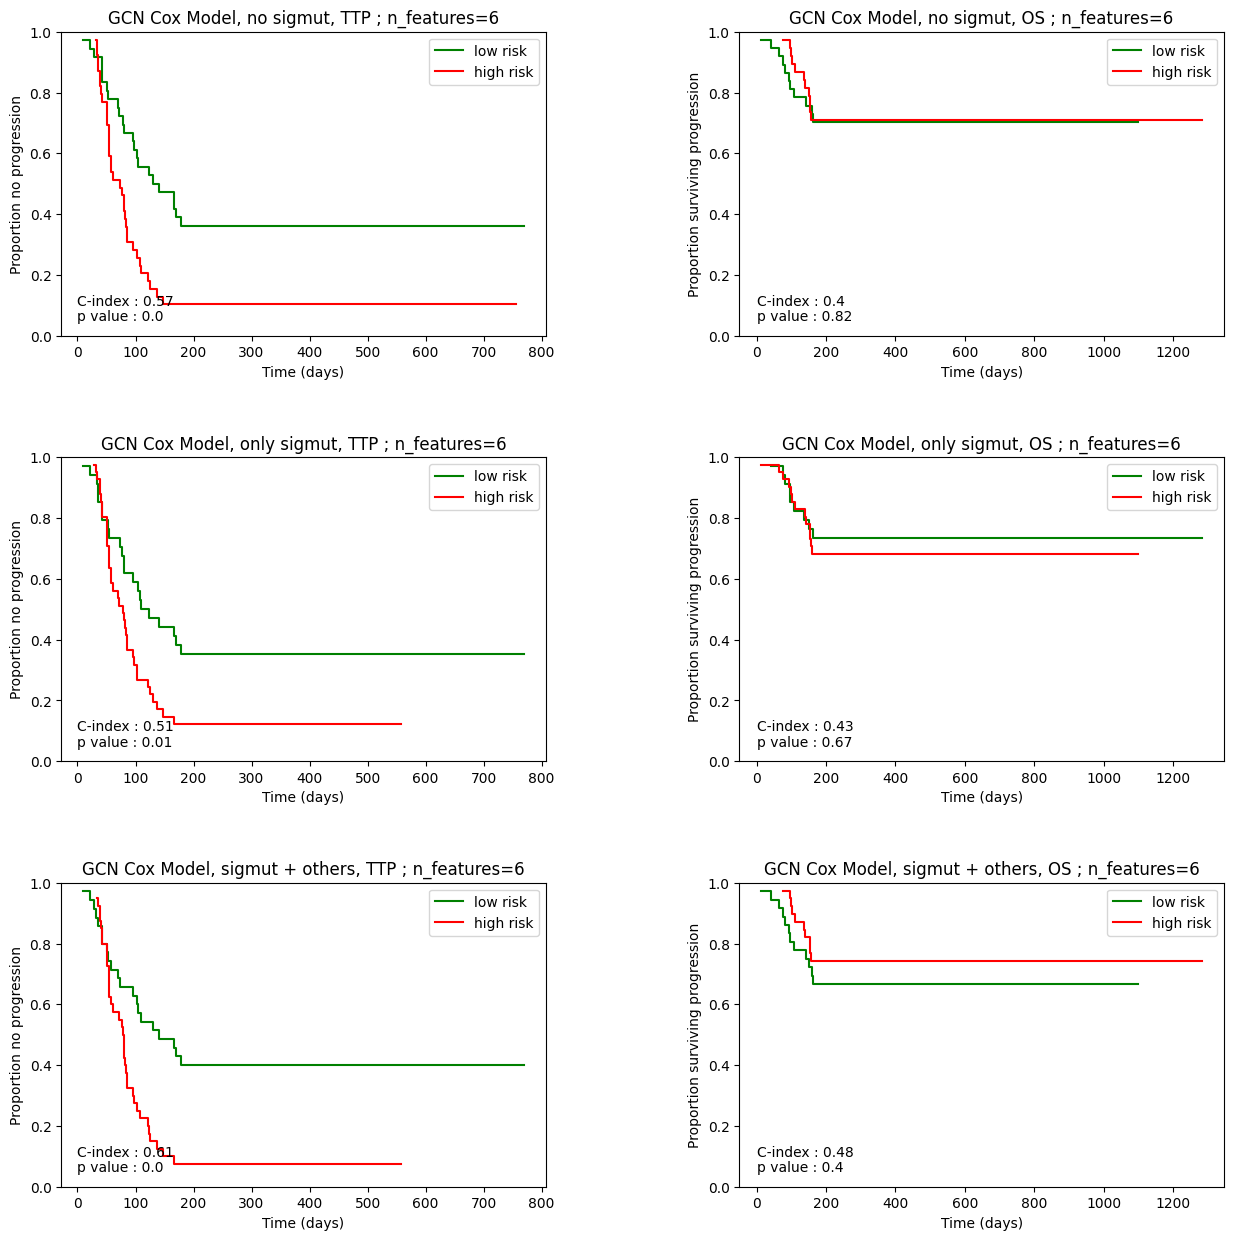

In [31]:
fig = plt.figure()

# NO SIGMUT
# TTP :
ax0 = fig.add_subplot(321)
ax0.step(time_axis_low_risk_no_sigmut_ttp, prob_axis_low_risk_no_sigmut_ttp, where='post',color='green',label='low risk')
ax0.step(time_axis_high_risk_no_sigmut_ttp, prob_axis_high_risk_no_sigmut_ttp, where='post',color='red',label='high risk')
ax0.set_xlabel('Time (days)')
ax0.set_ylabel('Proportion no progression')
ax0.set_title(f'GCN Cox Model, no sigmut, TTP ; n_features={n_features}')
ax0.text(0,0.1,f'C-index : {c_index_no_sigmut_ttp}')
ax0.text(0,0.05,f'p value : {p_value_no_sigmut_ttp}')
ax0.set_ylim(0,1)
ax0.legend()

# OS :
ax1 = fig.add_subplot(322)
ax1.step(time_axis_low_risk_no_sigmut_os, prob_axis_low_risk_no_sigmut_os, where='post',color='green',label='low risk')
ax1.step(time_axis_high_risk_no_sigmut_os, prob_axis_high_risk_no_sigmut_os, where='post',color='red',label='high risk')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion surviving progression')
ax1.set_title(f'GCN Cox Model, no sigmut, OS ; n_features={n_features}')
ax1.text(0,0.1,f'C-index : {c_index_no_sigmut_os}')
ax1.text(0,0.05,f'p value : {p_value_no_sigmut_os}')
ax1.set_ylim(0,1)
ax1.legend()

# ONLY SIGMUT
# TTP :
ax3 = fig.add_subplot(323)
ax3.step(time_axis_low_risk_only_sigmut_ttp, prob_axis_low_risk_only_sigmut_ttp, where='post',color='green',label='low risk')
ax3.step(time_axis_high_risk_only_sigmut_ttp, prob_axis_high_risk_only_sigmut_ttp, where='post',color='red',label='high risk')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Proportion no progression')
ax3.set_title(f'GCN Cox Model, only sigmut, TTP ; n_features={n_features}')
ax3.text(0,0.1,f'C-index : {c_index_only_sigmut_ttp}')
ax3.text(0,0.05,f'p value : {p_value_only_sigmut_ttp}')
ax3.set_ylim(0,1)
ax3.legend()

# OS :
ax4 = fig.add_subplot(324)
ax4.step(time_axis_low_risk_only_sigmut_os, prob_axis_low_risk_only_sigmut_os, where='post',color='green',label='low risk')
ax4.step(time_axis_high_risk_only_sigmut_os, prob_axis_high_risk_only_sigmut_os, where='post',color='red',label='high risk')
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Proportion surviving progression')
ax4.set_title(f'GCN Cox Model, only sigmut, OS ; n_features={n_features}')
ax4.text(0,0.1,f'C-index : {c_index_only_sigmut_os}')
ax4.text(0,0.05,f'p value : {p_value_only_sigmut_os}')
ax4.set_ylim(0,1)
ax4.legend()

# SIGMUT + OTHER BIOMARKERS
# TTP :
ax6 = fig.add_subplot(325)
ax6.step(time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp, where='post',color='green',label='low risk')
ax6.step(time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp, where='post',color='red',label='high risk')
ax6.set_xlabel('Time (days)')
ax6.set_ylabel('Proportion no progression')
ax6.set_title(f'GCN Cox Model, sigmut + others, TTP ; n_features={n_features}')
ax6.text(0,0.1,f'C-index : {c_index_comb_ttp}')
ax6.text(0,0.05,f'p value : {p_value_comb_ttp}')
ax6.set_ylim(0,1)
ax6.legend()

# OS :
ax7 = fig.add_subplot(326)
ax7.step(time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os, where='post',color='green',label='low risk')
ax7.step(time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os, where='post',color='red',label='high risk')
ax7.set_xlabel('Time (days)')
ax7.set_ylabel('Proportion surviving progression')
ax7.set_title(f'GCN Cox Model, sigmut + others, OS ; n_features={n_features}')
ax7.text(0,0.1,f'C-index : {c_index_comb_os}')
ax7.text(0,0.05,f'p value : {p_value_comb_os}')
ax7.set_ylim(0,1)
ax7.legend()

plt.gcf().set_size_inches(15,15)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

No sigmut TTP :


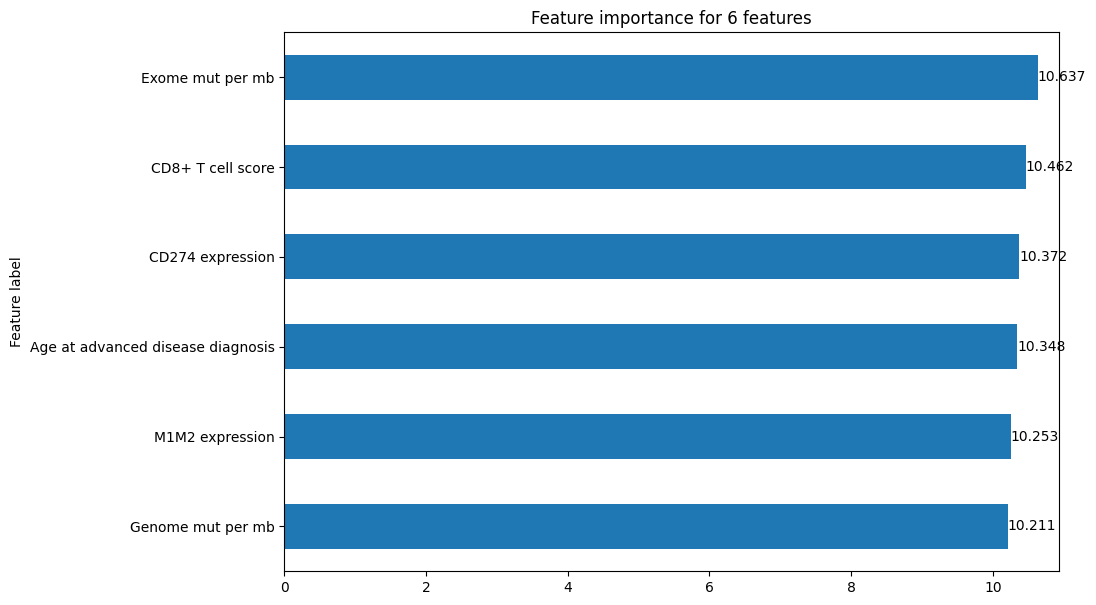

No sigmut OS :


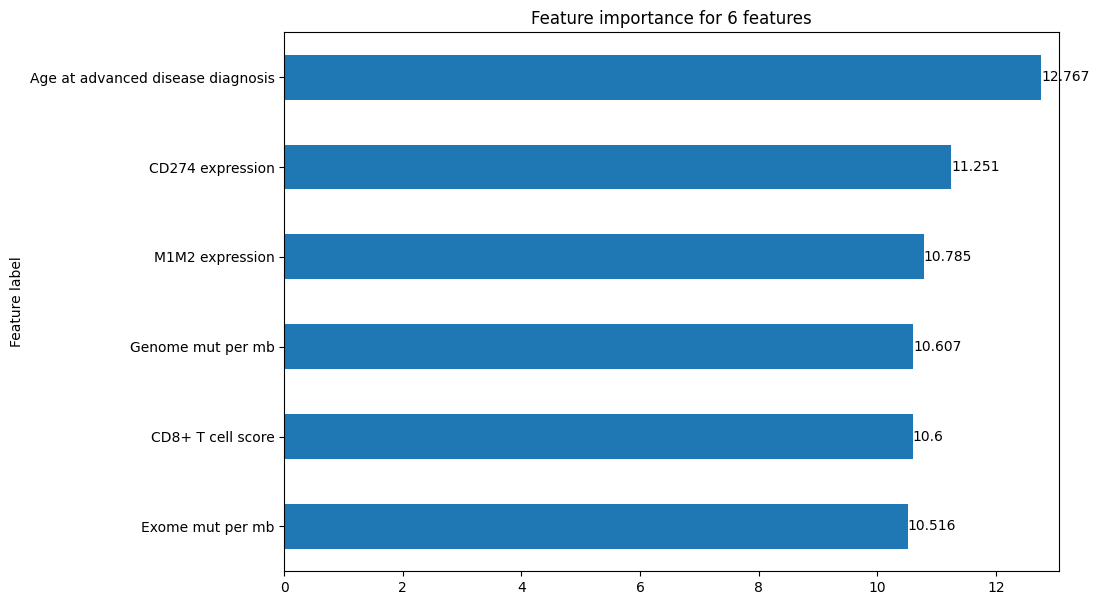

Only sigmut TTP :


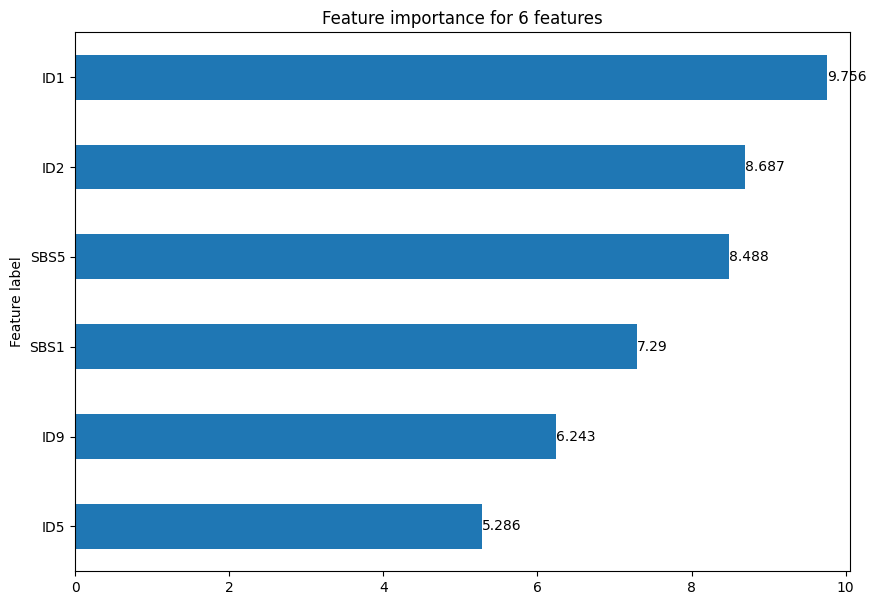

Only sigmut OS :


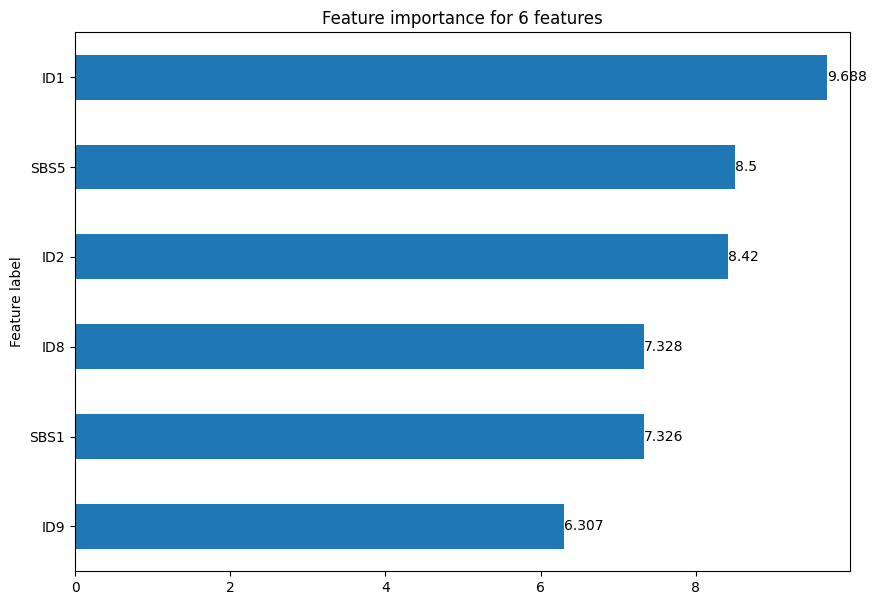

Initial biomarkers + sigmut TTP


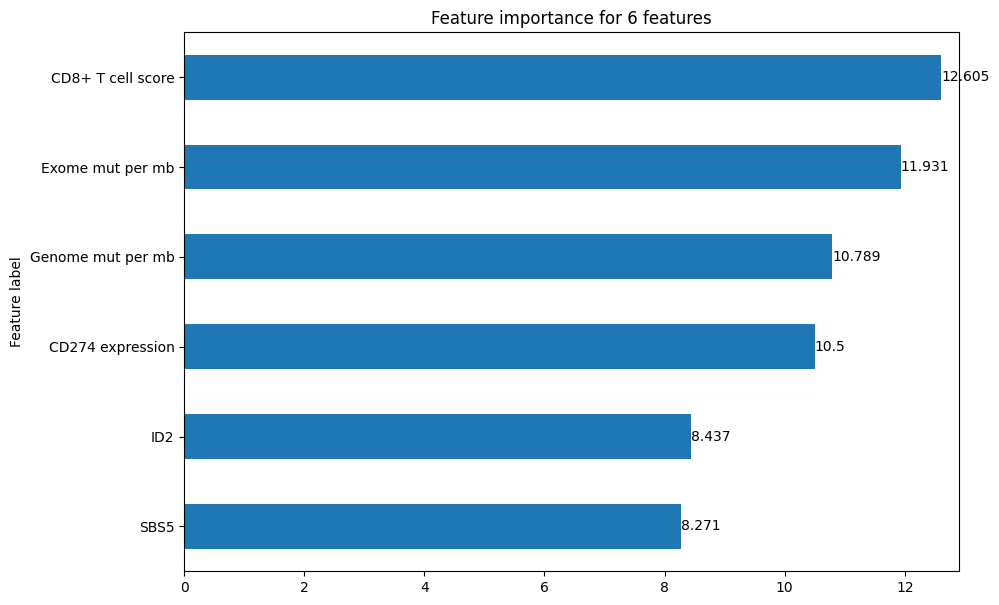

Initial biomarkers + sigmut OS


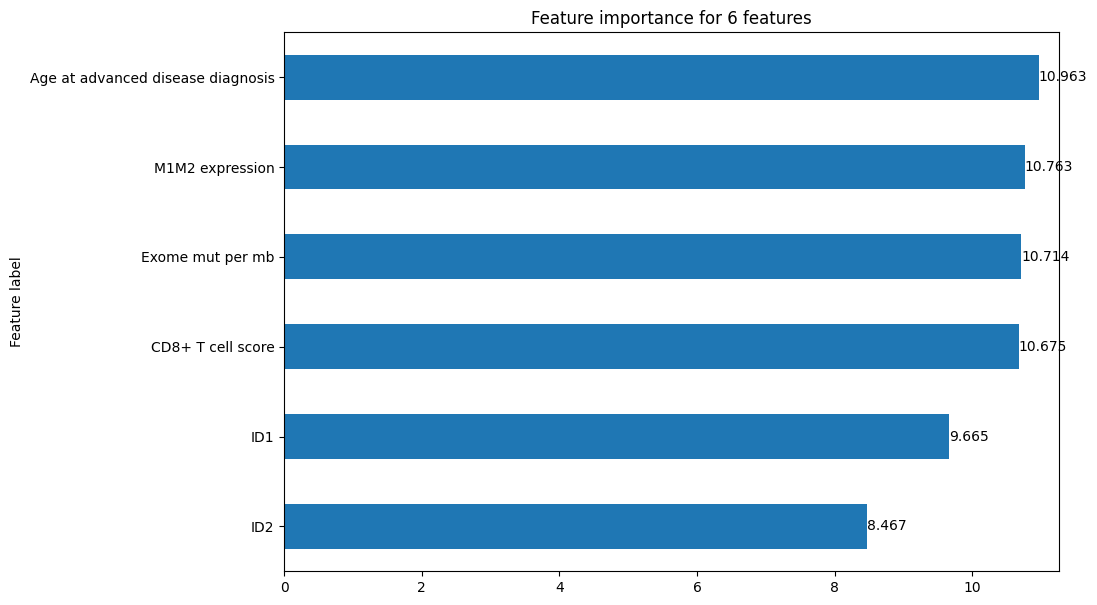

In [32]:
print("No sigmut TTP :")
explanation_no_sigmut_ttp.visualize_feature_importance(feat_labels=features_name_no_sigmut_ttp)

print("No sigmut OS :")
explanation_no_sigmut_os.visualize_feature_importance(feat_labels=features_name_no_sigmut_os)

print("Only sigmut TTP :")
explanation_only_sigmut_ttp.visualize_feature_importance(feat_labels=features_name_only_sigmut_ttp)

print("Only sigmut OS :")
explanation_only_sigmut_os.visualize_feature_importance(feat_labels=features_name_only_sigmut_os)

print("Initial biomarkers + sigmut TTP")
explanation_comb_ttp.visualize_feature_importance(feat_labels=features_name_comb_ttp)

print("Initial biomarkers + sigmut OS")
explanation_comb_os.visualize_feature_importance(feat_labels=features_name_comb_os)